In [23]:
from toneMap import ToneMap
import drawlines
import render
import numpy as np
import cv2
from skimage import io, color, filters, transform, exposure
from scipy import signal, sparse
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import gf
from skimage.color import rgb2gray


In [112]:
## Tone map parameters
## ua = 105,ub = 225
### bright 
##sigb = 9

### dark
## mud = 90
## sigd = 11

## range [0,1] to [0,255]
def to255Int(A, c=255):
    return np.uint8((A - np.amin(A))/(np.amax(A)-np.amin(A))*c)

def showimg(img,save=False,namesave = "pic",scale=255):
    plt.axis('off')
    plt.imshow(img,cmap='gray')
    if save == True:
        #plt.savefig(namesave)
        cv2.imwrite(namesave,img*scale)
    plt.show()

picname = 'data/3--17.jpg'#'data/john.jpg'
ori_img = plt.imread(picname)


### Lines drawing

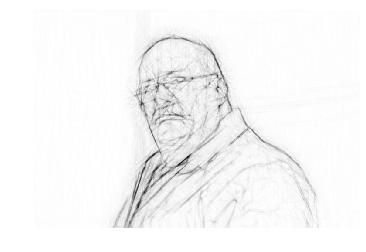

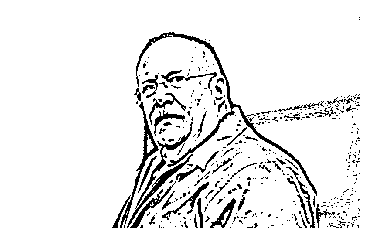

In [95]:
#### Lines drawing
## method 1
L = drawlines.linedrawing(ori_img,8,x=30,y=30,size=0)
## method 2
L1 = drawlines.XDOG2(picname)

## draw
showimg(L)
showimg(L1)

### Tone Map

In [107]:
def getgrayli(name):
    #name = 'artist-sketh/4.jpeg'#'./artist-sketh/1.jpg'
    #showhist(name)
    image = io.imread(name)
    grayscale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)#rgb2gray(image)
    ligray = grayscale.ravel()
    return ligray

def partita(ligray):
    dark = ligray[np.where(ligray<86)]
    mild1 = ligray[np.where(85<ligray)]
    mild = mild1[np.where(171>mild1)]
    bright = ligray[np.where(ligray>170)]
    return dark,mild,bright

def paralearn(dark,mild,bright):
    lenbright = len(bright)
    sigb = (1/lenbright)*sum([abs(x-1) for x in bright])

    ##mild
    ua = np.mean(mild)-np.sqrt(3)*np.std(mild)
    ub = np.mean(mild)+np.sqrt(3)*np.std(mild)

    ## dark 
    mua = np.mean(dark)
    sigd = np.std(dark)
    print(sigb)
    print(ua,ub)
    print(mua,sigb)
    return ua,ub,sigb,mua,sigd

### Tune different sketch image, get different hist parameters
ligray = getgrayli('artist-sketh/1.jpg')
dark,mild,bright = partita(ligray)
ua,ub,sigb,mub,sigd = paralearn(dark,mild,bright)

204.10505322868474
91.84976701284057 176.06422558403426
49.467649194418826 204.10505322868474


In [108]:
J3 = ToneMap(ori_img,ua,ub,sigb,mub,sigd)

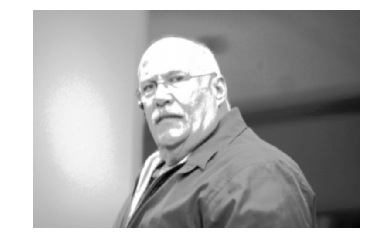

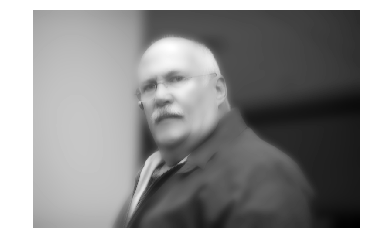

In [96]:
### Tone map method 1

J = ToneMap(ori_img,105,225,9,90,11)

### Tone map mehtod 2
lum = rgb2gray(ori_img)
r = 8
eps = 0.05
J2 = gf.guided_filter(lum, lum, r, eps)

showimg(J,True,'Tone-oldman1.jpg')

showimg(J2,True,'Tone-oldmanGF.jpg')


### Render Texture

In [103]:
def Rendertext(J,texturename='pencils/pencil0.jpg'):
    yuvimg = color.rgb2yuv(ori_img)
    H = io.imread('pencils/pencil0.jpg',as_gray=True)
    T = render.renderTexture(H,J,1)
    #Image.fromarray(to255Int(rendimg), "L").show()

    # To show texture image, transform rendimg to [0,255], but we will use T as input of last step
    textureimg = to255Int(T)
    showimg(textureimg)
    return textureimg,T


In [104]:
### another implementation
#imgy = yuvimg[:,:,0]
#finaimg = Texture.gen_pencil_texture(imgy,H,J)

In [124]:
### multiply L and 
def combineall(L,T,savename):
    R = np.multiply(L,T)
    yuvimg = color.rgb2yuv(ori_img)
    yuvimg[:,:,0] = R
    Res = exposure.rescale_intensity(color.yuv2rgb(yuvimg), in_range=(0, 1))#
    showimg(R)
    showimg(Res,True,savename)#'tone-jhres2.jpg'
    #Image.fromarray(Res, "RGB").save(savename)
    return Res

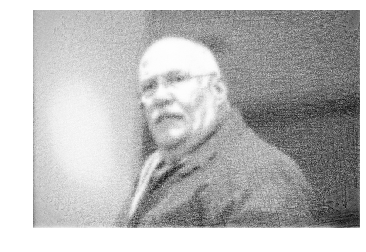

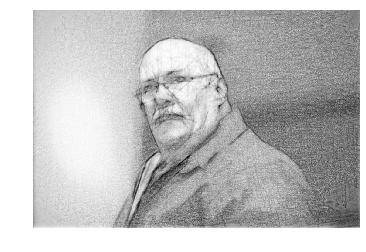

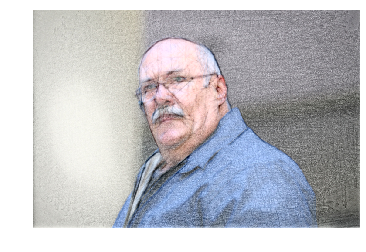

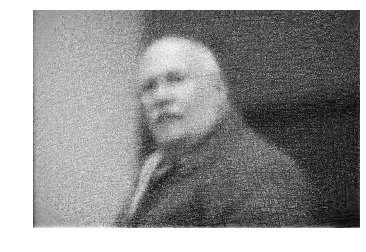

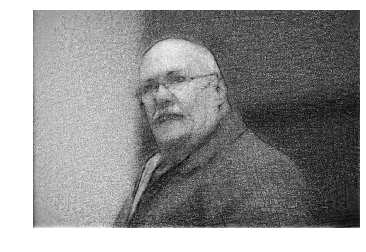

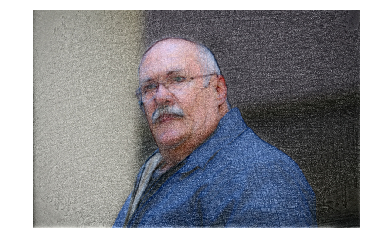

In [125]:
####  Tune: J1, J2,...
###  pencil0, pencil1, .... （hatch, blending）

textureimg,T = Rendertext(J)
Res = combineall(L,T,'res-oldman.jpg')
textureimg,T = Rendertext(J2)
Res = combineall(L,T,'res-oldmanGF.jpg')

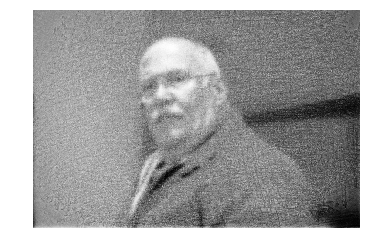

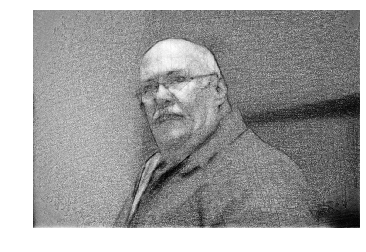

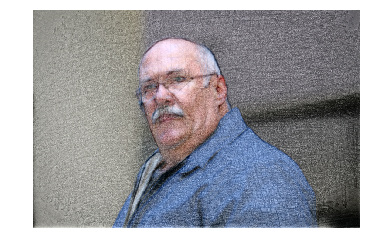

In [126]:
textureimg,T = Rendertext(J3)
Res = combineall(L,T,'res-oldmansketch1.jpg')